In [5]:
from multidataset import MultiDataset
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from multimodel import Net as Model
from utils import accuracy
import sklearn
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#Parameters to change, can change model_type to 'best' or 'last'
use_jet_pt = True
use_jet_mass = True
N = 8
model_type = 'best'
extra_name = ''
#Testing path
test_path = '../../datasets/n-subjettiness_data/test_all.npy'

#model path
model_path = 'models/MultiBody' + str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+'_'+ model_type + extra_name

#Loading testing dataset
test_set = MultiDataset(test_path, N, use_jet_pt, use_jet_mass)
testloader = DataLoader(test_set, shuffle=False, batch_size=256, num_workers=30, pin_memory=True, persistent_workers=True)

#loading model
model = Model(N, use_jet_pt, use_jet_mass).cuda().double()
model.load_state_dict(torch.load(model_path))
model.eval()

Net(
  (dense1): Linear(in_features=22, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=200, bias=True)
  (dense3): Linear(in_features=200, out_features=50, bias=True)
  (dense4): Linear(in_features=50, out_features=50, bias=True)
  (dense5): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [6]:
def evaluate_model(model, test_loader):
   
    #Find loss and accuracy
    crit = torch.nn.BCELoss()
    val_loss_total=0
    test_top1_total=0
    acc=0
    _, labels=test_set[:]
    total_preds = []
    with torch.no_grad():
        for x,y in tqdm(test_loader):
            x = x.cuda()
            y = y.cuda()
            pred = model(x)
            loss = crit(pred, y)
            val_loss_total += loss.item()
            #accuracy is determined by rounding. Any number <= 0.5 get's rounded down to 0
            #The rest get rounded up to 1
            top1 = accuracy_score(pred[:,1].round().cpu(), y[:,1].cpu(), normalize=False)
            test_top1_total += top1.item()
            total_preds.append(pred.cpu().numpy())
    total_preds = np.concatenate(total_preds, axis=0)
    print("Loss: "+str(val_loss_total/len(testloader)))    
    print("Accuracy: "+str(test_top1_total/len(test_set)))
    fpr, tpr, thresholds = roc_curve(
            labels[:,1][...,None], np.array(total_preds)[:,1][...,None])
    
    rej_at_30_marker  = None
    rej_at_50_marker  = None
    rej_at_80_marker  = None

    for i in range(len(fpr)):
        if(tpr[i] >= .30 and rej_at_30_marker is None):
            rej_at_30_marker = 1 / fpr[i]
            print("Background rejection at 30\% signal efficiency:" +
                        str(rej_at_30_marker))
        if(tpr[i] >= .50 and rej_at_50_marker is None):
            rej_at_50_marker = 1 / fpr[i]
            print("Background rejection at 50\% signal efficiency:" +
                        str(rej_at_50_marker))
        if(tpr[i] >= .80 and rej_at_80_marker is None):
            rej_at_80_marker = 1 / fpr[i]
            print( "Background rejection at 80\% signal efficiency:" +
                   str(rej_at_80_marker))
    current = sklearn.metrics.auc(fpr, tpr)
    print("AUC:"+str(current))
    return fpr,tpr,current,labels, total_preds
    
print("Performance on test set")
fpr, tpr, current,labels,total_preds = evaluate_model(model,testloader)

Performance on test set


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:04<00:00, 323.90it/s]


Loss: 0.1766003942992638
Accuracy: 0.9281466625321343
Background rejection at 30\% signal efficiency:771.6525096525097
Background rejection at 50\% signal efficiency:200.05805805805807
Background rejection at 80\% signal efficiency:35.10591955032496
AUC:0.9798053081147364


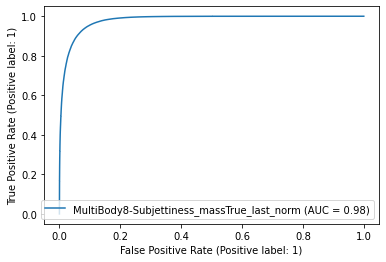

In [5]:
sklearn.metrics.RocCurveDisplay.from_predictions(labels[:,1][...,None], total_preds[:,1][...,None], name='MultiBody' + str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_'+ model_type+extra_name)
plt.show()

In [8]:
data, labels=test_set[:]

In [7]:
len(testloader)

1563

In [13]:
#loading model
model2 = Model(N, True, True).cuda().double()
old_state_dict = torch.load(model_path)
new_state_dict = model2.state_dict()
for key in new_state_dict.keys():
    if key == 'dense1.weight':
        new_state_dict[key][:,0:3*(N-1)-1] = old_state_dict[key].clone()
    else:
        new_state_dict[key] = old_state_dict[key].clone()

In [12]:
model2.load_state_dict(new_state_dict)

<All keys matched successfully>